## Ejercicios UMAP sesion 8

### Manel Soler 

### **UMAP on Fashion MNIST**

In [1]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap



sns.set(style='white', context='poster')
mndata = MNIST('fashion-mnist/data/fashion')
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

## Apartado 1

Vamos a realizar una transfrmacion de los datos no supervisada, usando UMAP de modo que reduciremos la dimensionalidad a 2. Esto nos va a permtir hacer una representación de los datos :

In [2]:
%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(data)  # con n_neighbors especificado para 5

Wall time: 0 ns


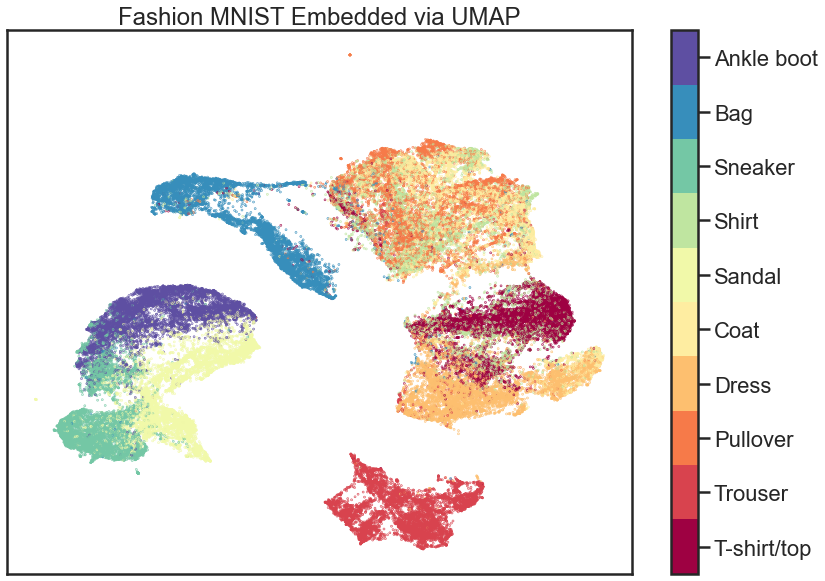

In [3]:
# Representación

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP');

## **Using Labels to Separate Classes (Supervised UMAP)**

Ahora vamos a realizar esta reducción de la dimensionalidad de forma supervisada, es decir, utilizando las etiquetas de cada uno de los datos. Veremos que los resultados son mejores, pues los clusters aparecen mucho más definidos. 



In [4]:
%time
embedding = umap.UMAP().fit_transform(data, y=target)

Wall time: 0 ns


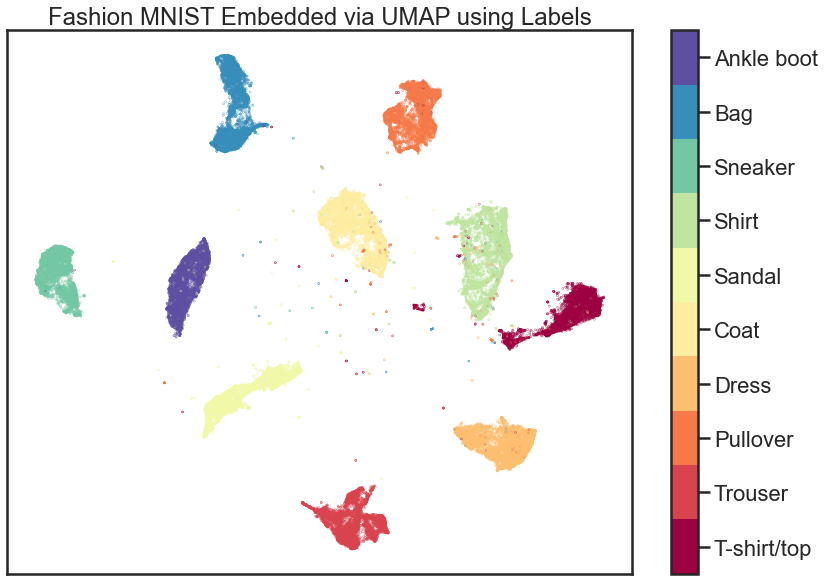

In [5]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Labels');

Podemos comparar la estructura interna de cada cluster y la estrucutra global de esta representación frente a la anterior y vemos que se conservan . Los datos aparecen más agrupados y definidos pero las proximidades entre datos de diferentes etiquetas y la estructura interna de estos se parecen

## Using Partial Labelling (Semi-Supervised UMAP)

Vamos a esconder una parte de las etiquetas de modo que la clasificación que hagamos sera aprendizaje semi-supervisado

In [6]:
# escondemos algunas

masked_target = target.copy().astype(np.int8)
masked_target[np.random.choice(70000, size=10000, replace=False)] = -1

UMAP interprestara las -1 etiquetas como no etiquetadas y las clasificará como él crea

In [13]:
%time
fitter = umap.UMAP().fit(data, y=masked_target)
embedding = fitter.embedding_


Wall time: 0 ns


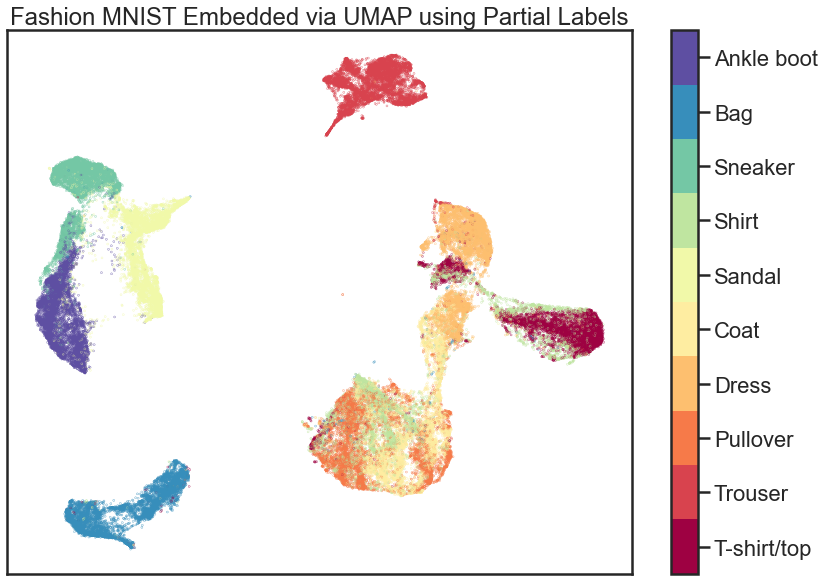

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Partial Labels');

El algortimo ha  separado claramente casi todas las etiquetas. El resultado es mucho mejor que par el caso no supervisado

## Training with Labels and Embedding Unlabelled Test Data (Metric Learning with UMAP)

Ahora vamos a utilizar un conjunto de entrenamiento con el que entrenaremos nuestro algoritmo y después utilizaremos el conjunto test para comprovar como de buenas son las predicciones de nuestro modelo.

In [3]:
train_data = np.array(train)
test_data = np.array(test)
%time
mapper = umap.UMAP(n_neighbors=10).fit(train_data, np.array(train_labels))


Wall time: 0 ns


In [4]:
test_embedding = mapper.transform(test_data)

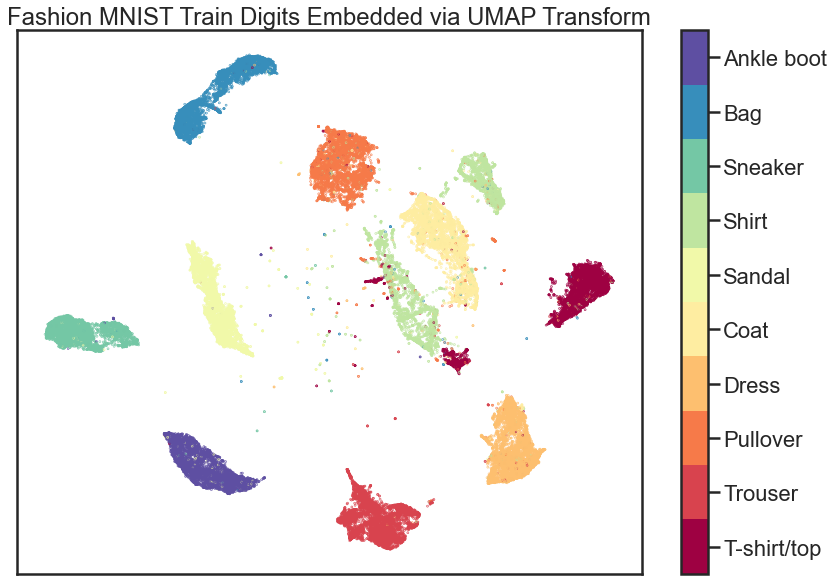

In [5]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(train_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via UMAP Transform');

# esto son los resultados para los datos de entrenamiento

 Como era de esperar la clasificación del conjunto de entrenamiento es muy buena. 
 
 Ahora pasamos a comprovar para el conjunto de test

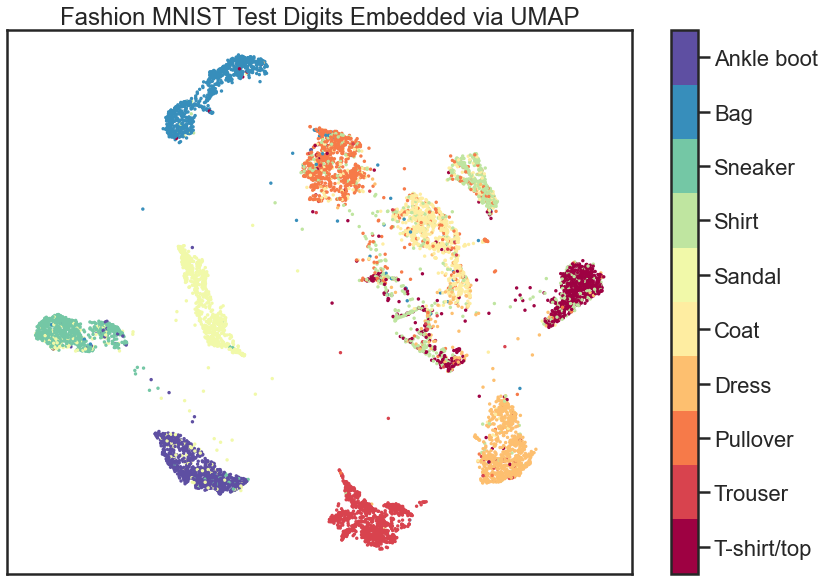

In [6]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*test_embedding.T, s=2, c=np.array(test_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Test Digits Embedded via UMAP');

Vemos que los resultados tambien son muy buenos. La mayor confusion es dada entre `T.shirts` y `Shirts` y  entre `Pullovers` y `Coats`



## Using UMAP for Clustering (UMAP enhanced clustering)

Ahora, partiendo del embedding de los datos de test, vamos a realizar un clustering utilizando el algoritmo de k means 

In [7]:
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(test_embedding)


Text(0.5, 1.0, 'Cluster con k-means a partir del embedding')

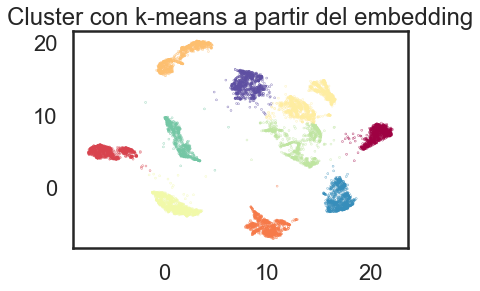

In [9]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')
plt.title("Cluster con k-means a partir del embedding")

In [10]:
# Representamos los valores de las metricas de acierto

(
    adjusted_rand_score(test_labels, kmeans_labels),
    adjusted_mutual_info_score(test_labels, kmeans_labels)
)

(0.6591033915139355, 0.7331334232725453)

## probamos con HDBSCAN 


In [11]:
import hdbscan
from sklearn.decomposition import PCA

In [31]:
lowd_mnist = PCA(n_components=50).fit_transform(test_data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=600).fit_predict(lowd_mnist)

In [32]:
(
    adjusted_rand_score(test_labels, hdbscan_labels),
    adjusted_mutual_info_score(test_labels, hdbscan_labels)
)

(0.07039340787507721, 0.22277266447830946)

In [33]:
test_labels = np.array(test_labels)

Estos resultados tan pobres son debidos a que el algoritmo de Hdbscan etiqueta al ruido como `-1` , es decir , para élel ruido es otro cluster. Vamos a filtran solo para los clusters originales, sin ruido 

In [34]:
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(test_labels[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(test_labels[clustered], hdbscan_labels[clustered])
)

(0.17538207820023177, 0.40594551724763445)

Tampoco sale un buen resulado. Sabemos que HDBSCAN presenta resultados muy pobres para dimensionalidades muy altas y auqnue nosotros hemos reducido considerablemente esto mediante PCA, no es suficiente, pues seguimos trabajando con 50 dimensiones. 
No obstamte, hemos visto que si reducimos muchas más dimensiones con PCA, perdemos mucha varianza explicada, por lo que no podremos clasificarlo bien tampoco. 

Como solución a esto, intentaremos utulizar UMAP , para reducir las dimensiones a 2.

In [50]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=600).fit_predict(test_embedding)
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(test_labels[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(test_labels[clustered], hdbscan_labels[clustered])
)

(0.6855631268181602, 0.7610301598985917)

Vemos que, efectivamente, la dimensionalidad era la culpable de los malos resultados

## UMAP enhanced clustering

intentamos mejorar los resultados, afinando los hiperparámetros del  K means
Vamos a realizar los siguientes cambios : 

*  **n_neighbors:** Vamos a elevar el número de vecinos a 20  para que no se focalize en estructuras muy locales, ya que estas pueden estar afectadas por el ruido

*  **min_dist:** Para empaquetar lo máximo posible los puntos, la vamos a definir como 0




In [42]:
tunned_embedding = umap.UMAP(
    n_neighbors=20,
    min_dist=0.5,
    n_components=2,
    random_state=42,
).fit(train_data, np.array(train_labels))
clusterable_embedding = tunned_embedding.transform(test_data)
#kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(clusterable_embedding)

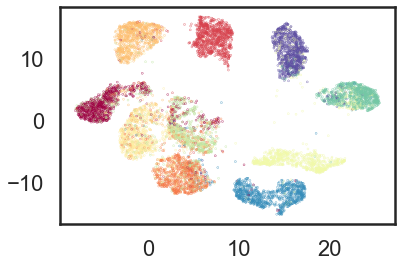

In [41]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=test_labels, s=0.1, cmap='Spectral');

Vemos que los clusters estan mucho más separados y definidos,aunque en algunos aparece mucho ruido, quizas por el numero de vecinos tan alto que hemos definido. 

## K-means

In [49]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(clusterable_embedding)

(
    adjusted_rand_score(test_labels, kmeans_labels),
    adjusted_mutual_info_score(test_labels, kmeans_labels)
)

(0.6744781157838503, 0.7331841803536311)

La predicción ha mejorado, pero no considerablemente

## HDBSCAN 
Provamos ahora con este embding

In [43]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [48]:

(
    adjusted_rand_score(test_labels, labels),
    adjusted_mutual_info_score(test_labels, labels)
)

(0.6916346334628011, 0.7367024580600197)

Resultados, desechando el ruido :

In [46]:


clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(test_labels[clustered], labels[clustered]),
    adjusted_mutual_info_score(test_labels[clustered], labels[clustered])
)

(0.8734197078515943, 0.8570479737581166)

Vemos que son resultados mucho mejores que lo obtenido anteriormente. Como comentabamos la dimensionalidad había castigado claramente los resultados del HDBSCAN